## **Step 2**

### **a. Import, structure and graph the daily factor returns**

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import probplot
import warnings
from statsmodels.stats.outliers_influence import OLSInfluence
import cvxpy as cp

pd.set_option('display.float_format', lambda x: '%.5f' % x)
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

[*********************100%%**********************]  1 of 1 completed


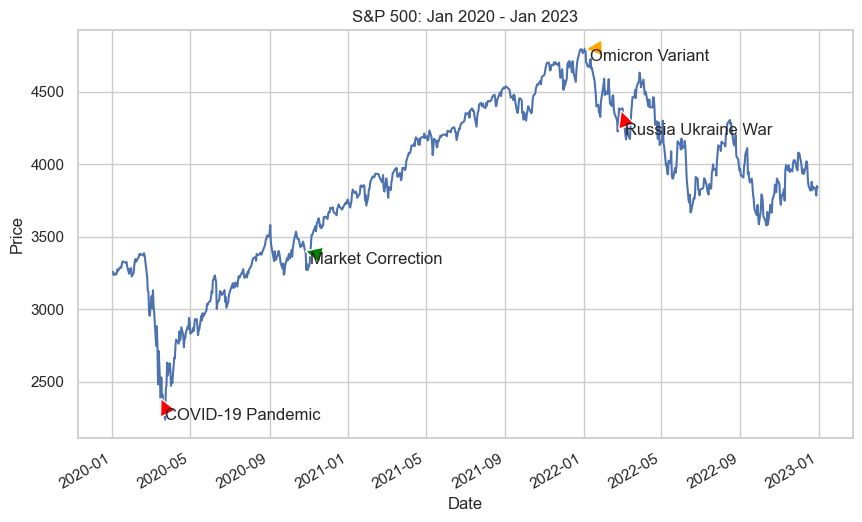

In [2]:
# download S&P 500 data
sp500_data = yf.download('^GSPC', start="2020-01-01", end="2023-01-01")

# line plot
sp500_data['Adj Close'].plot(figsize=(10,6))
plt.title('S&P 500: Jan 2020 - Jan 2023')
plt.ylabel('Price')

# annotations
plt.annotate('COVID-19 Pandemic', 
             xy=('2020-03-16', sp500_data.loc['2020-03-16', 'Adj Close']), 
             xytext=('2020-03-23', sp500_data.loc['2020-03-23', 'Adj Close']), 
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.annotate('Market Correction', 
             xy=('2020-10-26', sp500_data.loc['2020-10-26', 'Adj Close']), 
             xytext=('2020-11-02', sp500_data.loc['2020-11-02', 'Adj Close']), 
             arrowprops=dict(facecolor='green', shrink=0.05))

plt.annotate('Omicron Variant', 
             xy=('2022-01-04', sp500_data.loc['2022-01-04', 'Adj Close']), 
             xytext=('2022-01-11', sp500_data.loc['2022-01-11', 'Adj Close']), 
             arrowprops=dict(facecolor='orange', shrink=0.05))

plt.annotate('Russia Ukraine War', 
             xy=('2022-02-28', sp500_data.loc['2022-02-28', 'Adj Close']), 
             xytext=('2022-03-07', sp500_data.loc['2022-03-07', 'Adj Close']), 
             arrowprops=dict(facecolor='red', shrink=0.05));

In [3]:
# 3 factors data import and data wrangling
data_3f = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', skiprows=3)
data_3f = data_3f[:-1]
data_3f.columns = ['Date', 'RM-RF', 'SMB', 'HML', 'RF']
data_3f['Date'] = pd.to_datetime(data_3f['Date'], format='%Y%m%d')

data_3f.index = data_3f['Date']

# slice data for the required timeframe (3 years)
start_date = '2020-01-01'
end_date = '2023-01-01'

factors_data_3f = data_3f.loc[start_date:end_date]

risk_free = factors_data_3f['RF']

factors_data_3f.drop(columns=['Date', 'RF'], inplace=True)

# show sample data
factors_data_3f.sample(5)

,RM-RF,SMB,HML
Date,,,
2022-05-11,-1.95000,-1.11000,2.59000
2022-10-12,-0.27000,0.08000,0.02000
2022-07-12,-0.88000,0.73000,0.51000
2020-05-04,0.54000,0.21000,-1.27000
2020-07-08,0.91000,0.30000,-0.47000


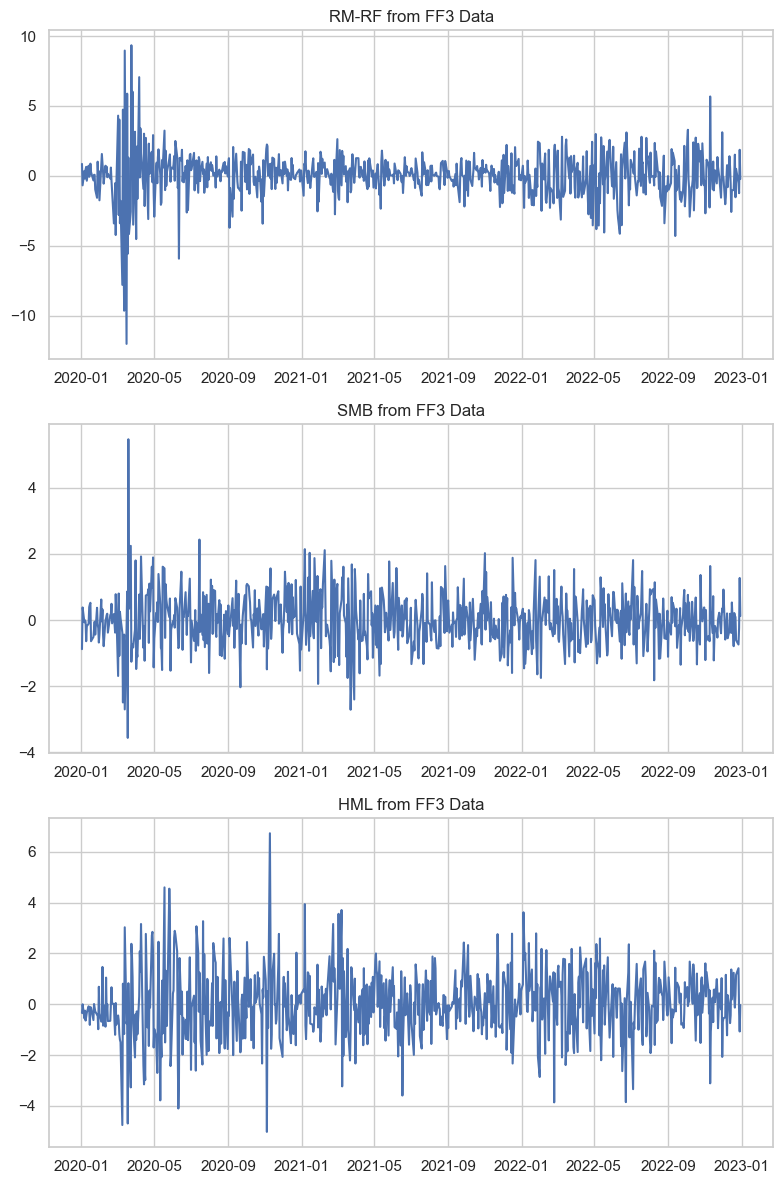

In [4]:
# line plots for the 3 factors
nrows = len(factors_data_3f.columns)
fig, ax = plt.subplots(nrows=nrows, figsize=(8, 12))

for i in range(nrows):
    ax[i].plot(factors_data_3f[factors_data_3f.columns[i]])
    ax[i].set_title(factors_data_3f.columns[i] + ' from FF3 Data')

fig.tight_layout();

In [5]:
# 5 factors data import and data wrangling
data_5f = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3)
data_5f = data_5f[:-1]
data_5f.columns = ['Date', 'RM-RF', 'SMB', 'HML', 'CMA', 'RMW', 'RF']
data_5f['Date'] = pd.to_datetime(data_5f['Date'], format='%Y%m%d')

data_5f.index = data_5f['Date']

# slice data for the required timeframe (3 years)
factors_data_5f = data_5f.loc[start_date:end_date]

factors_data_5f.drop(columns=['Date', 'RF'], inplace=True)

# show sample data
factors_data_5f.sample(5)

,RM-RF,SMB,HML,CMA,RMW
Date,,,,,
2020-06-26,-2.44000,-0.20000,-1.41000,0.01000,0.63000
2022-03-09,2.80000,0.00000,-2.09000,-0.42000,-1.53000
2022-10-25,1.78000,1.02000,-1.52000,-1.19000,-1.22000
2021-04-22,-0.77000,0.64000,-0.77000,-0.19000,-0.21000
2020-08-13,-0.01000,-0.14000,-1.33000,-0.64000,-0.50000


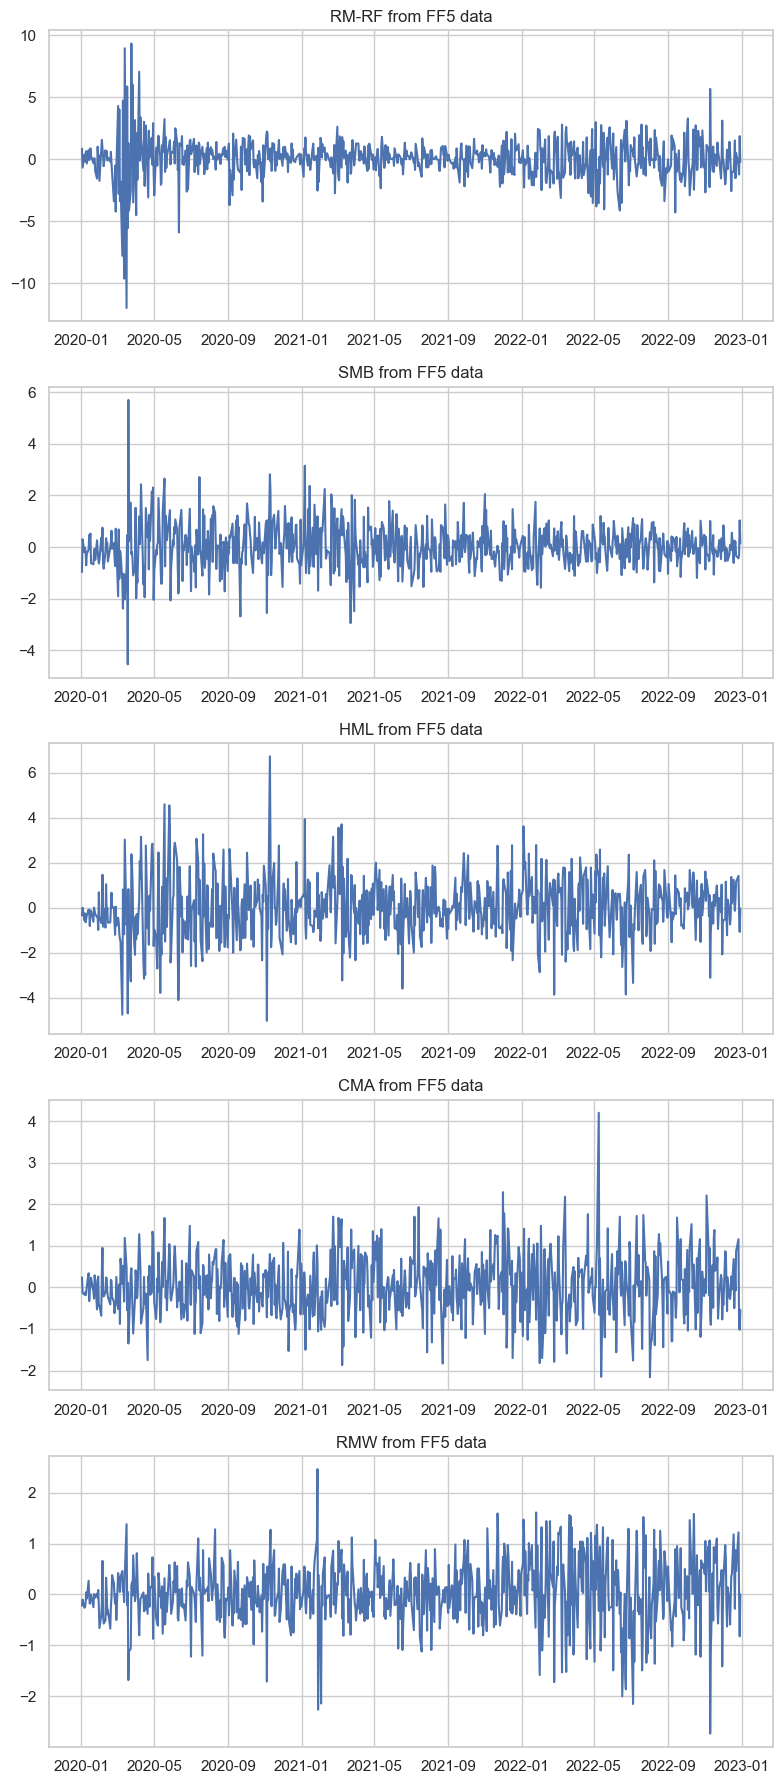

In [6]:
# line plots for the 5 factors
nrows = len(factors_data_5f.columns)
fig, ax = plt.subplots(nrows=nrows, figsize=(8, 18))

for i in range(nrows):
    ax[i].plot(factors_data_5f[factors_data_5f.columns[i]])
    ax[i].set_title(factors_data_5f.columns[i] + ' from FF5 data')

fig.tight_layout();

### **b. Collect and compute correlations of the changes in the factor returns**

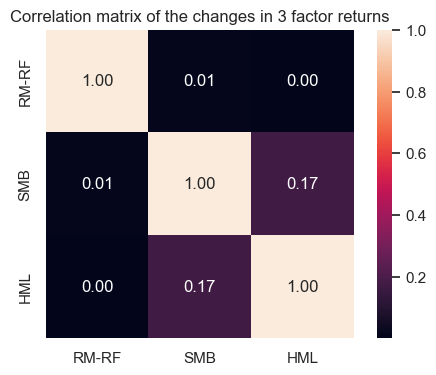

In [7]:
# compute and plot correlation matrix of the changes in 3 factor returns
corr_3f = factors_data_3f.pct_change().corr()

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr_3f, annot=True, fmt='.2f', ax=ax, square=True)
ax.set_title('Correlation matrix of the changes in 3 factor returns')
plt.show()

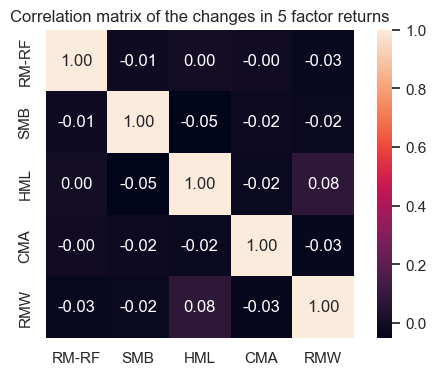

In [8]:
# compute and plot correlation matrix of the changes in 5 factor returns
corr_5f = factors_data_5f.pct_change().corr()

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr_5f, annot=True, fmt='.2f', ax=ax, square=True)
ax.set_title('Correlation matrix of the changes in 5 factor returns')
plt.show()

### **c. Collect economic data for the period**

In [9]:
# instantiate a list of tickers to form a diversified industry portfolio
# including technology, healthcare, financial services, consumer goods, energy
tickers = ['AAPL', 'JNJ', 'V', 'PG', 'XOM']

# set equal weights to create a naive portfolio
weights_equal = np.array([1/len(tickers)] * len(tickers))

# download data
data = yf.download(tickers, start_date, end_date)['Adj Close']

# compute percentage returns
returns_data = data.pct_change()

# Compute mean returns and covariance matrix
mean_returns = np.array(returns_data.mean())
cov_matrix = np.array(returns_data.cov())

[*********************100%%**********************]  5 of 5 completed


In [10]:
# Compute expected return and volatility of the naive portfolio
portfolio_return_ew = np.dot(mean_returns, weights_equal)
portfolio_volatility_ew = np.sqrt(np.dot(weights_equal.T, np.dot(cov_matrix, weights_equal)))

print(f"Equally Weighted Portfolio:\nExpected Return: {portfolio_return_ew:.4f}\nVolatility: {portfolio_volatility_ew:.4f}")

Equally Weighted Portfolio:
Expected Return: 0.0007
Volatility: 0.0150


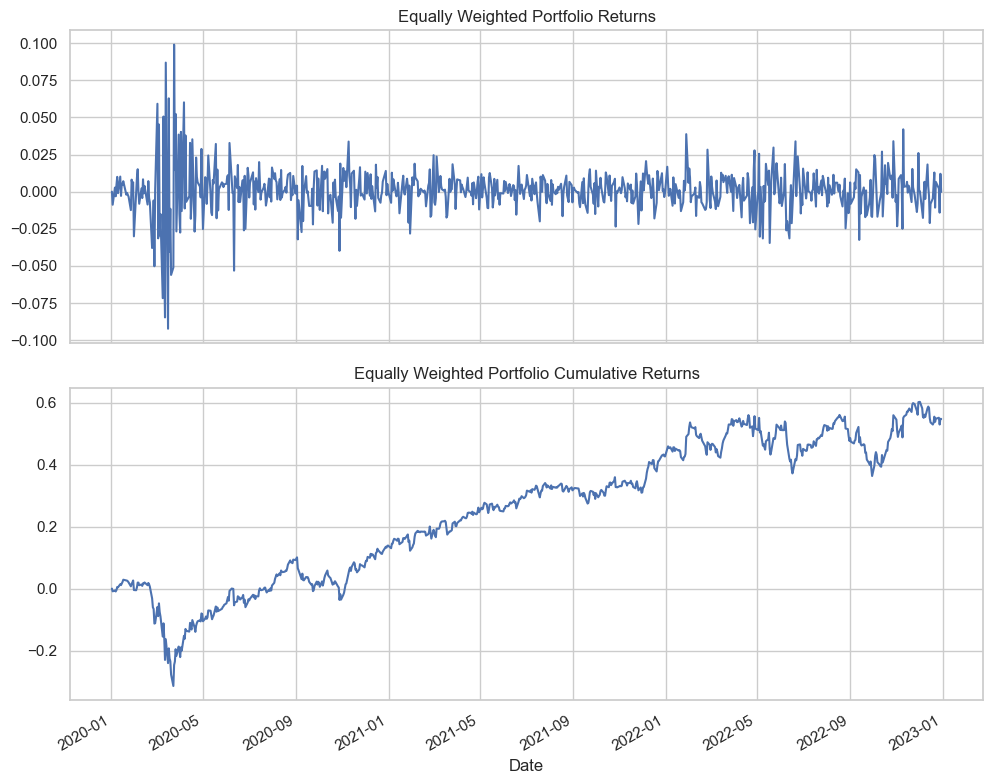

In [11]:
# compute and plot daily returns and cumulative returns of the portfolio
portfolio_returns_ew = np.sum(returns_data * weights_equal, axis=1)
cumulative_returns_ew = (1 + portfolio_returns_ew).cumprod() - 1

fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

portfolio_returns_ew.plot(ax=ax[0], title='Equally Weighted Portfolio Returns')
cumulative_returns_ew.plot(ax=ax[1], title='Equally Weighted Portfolio Cumulative Returns', sharex=ax[1])

plt.tight_layout();

## **Step 3**

### **OLS - Ordinary Least Squares**

In [12]:
# data pre-processing for model training

# add intercept to the 3 factor data
X_3f = sm.add_constant(factors_data_3f)

# compute target (r_i - r_f) for equally weighted portfolio
y_ew = portfolio_returns_ew - risk_free

# 80% train data and 20% test data
train_size = int(len(y_ew) * 0.8)

# split without shuffle to ensure the temporal order is preserved
X_train_3f, y_train_ew = X_3f.iloc[:train_size], y_ew.iloc[:train_size]
X_test_3f, y_test_ew = X_3f.iloc[train_size:], y_ew.iloc[train_size:]

In [13]:
# fit OLS model and print summary
model_ols_3f_ew = sm.OLS(y_train_ew, X_train_3f).fit()
print("OLS Regression Summary:")
print(model_ols_3f_ew.summary())

OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1262.
Date:                Thu, 15 Feb 2024   Prob (F-statistic):          1.14e-258
Time:                        17:00:38   Log-Likelihood:                 2247.3
No. Observations:                 604   AIC:                            -4487.
Df Residuals:                     600   BIC:                            -4469.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0

In [14]:
# compute and print r2 metrics for the ols model

y_pred_train_ols_3f_ew = model_ols_3f_ew.predict(X_train_3f)
y_pred_test_ols_3f_ew = model_ols_3f_ew.predict(X_test_3f)
y_resid_train_ols_3f_ew = y_train_ew - y_pred_train_ols_3f_ew
y_resid_test_ols_3f_ew = y_test_ew - y_pred_test_ols_3f_ew

r2_ols_train_3f_ew = r2_score(y_train_ew, y_pred_train_ols_3f_ew)
r2_ols_test_3f_ew = r2_score(y_test_ew, y_pred_test_ols_3f_ew)

print('R2 metrics for equally weighted portfolio using OLS regression with 3 factors:')
print(f'\tR2 Train: {round(r2_ols_train_3f_ew, 5)}')
print(f'\tR2 Test: {round(r2_ols_test_3f_ew, 5)}')

R2 metrics for equally weighted portfolio using OLS regression with 3 factors:
	R2 Train: 0.86323
	R2 Test: 0.37464


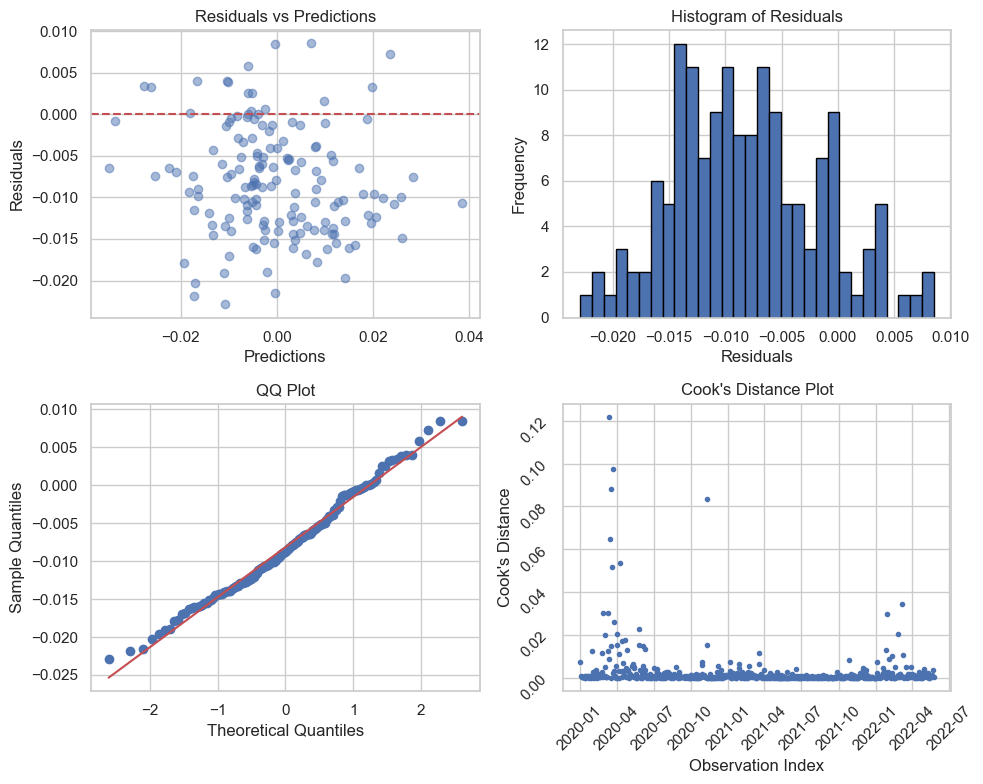

In [15]:
# plot and analyse residuals from the ols model

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].scatter(y_pred_test_ols_3f_ew, y_resid_test_ols_3f_ew, alpha=0.5)
ax[0, 0].axhline(y=0, color='r', linestyle='--')
ax[0, 0].set_title('Residuals vs Predictions')
ax[0, 0].set_xlabel('Predictions')
ax[0, 0].set_ylabel('Residuals')

ax[0, 1].hist(y_resid_test_ols_3f_ew, bins=30, edgecolor='black')
ax[0, 1].set_title('Histogram of Residuals')
ax[0, 1].set_xlabel('Residuals')
ax[0, 1].set_ylabel('Frequency')

probplot(y_resid_test_ols_3f_ew, plot=ax[1, 0], fit=True)
ax[1, 0].set_title('QQ Plot')
ax[1, 0].set_xlabel('Theoretical Quantiles')
ax[1, 0].set_ylabel('Sample Quantiles')

influence = OLSInfluence(model_ols_3f_ew)
cook_distance = influence.cooks_distance[0]

ax[1, 1].plot(cook_distance, 'bo', markersize=3)
ax[1, 1].set_title("Cook's Distance Plot")
ax[1, 1].set_xlabel('Observation Index')
ax[1, 1].set_ylabel("Cook's Distance")
plt.setp(ax[1, 1].get_yticklabels(), rotation=45)
plt.setp(ax[1, 1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

plt.show()

### **WLS - Weighted Least Squares**

In [16]:
# fit wls model and print summary
model_resid_3f_ew = sm.OLS(abs(y_resid_train_ols_3f_ew), sm.add_constant(y_pred_train_ols_3f_ew)).fit()
weights = 1 / (model_resid_3f_ew.fittedvalues**2)

model_wls_3f_ew = sm.WLS(y_train_ew, X_train_3f, weights=weights).fit()
print("WLS Regression Summary:")
print(model_wls_3f_ew.summary())

WLS Regression Summary:
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            WLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     1274.
Date:                Thu, 15 Feb 2024   Prob (F-statistic):          1.12e-259
Time:                        17:00:39   Log-Likelihood:                 2248.0
No. Observations:                 604   AIC:                            -4488.
Df Residuals:                     600   BIC:                            -4470.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0

In [17]:
# compute and print r2 metrics for the wls model

y_pred_train_wls_3f_ew = model_wls_3f_ew.predict(X_train_3f)
y_pred_test_wls_3f_ew = model_wls_3f_ew.predict(X_test_3f)
y_resid_train_wls_3f_ew = y_train_ew - y_pred_train_wls_3f_ew
y_resid_test_wls_3f_ew = y_test_ew - y_pred_test_wls_3f_ew

r2_wls_train_3f_ew = r2_score(y_train_ew, y_pred_train_wls_3f_ew)
r2_wls_test_3f_ew = r2_score(y_test_ew, y_pred_test_wls_3f_ew)

print('R2 metrics for equally weighted portfolio using WLS regression with 3 factors:')
print(f'\tR2 Train: {round(r2_wls_train_3f_ew, 5)}')
print(f'\tR2 Test: {round(r2_wls_test_3f_ew, 5)}')

R2 metrics for equally weighted portfolio using WLS regression with 3 factors:
	R2 Train: 0.86319
	R2 Test: 0.37511


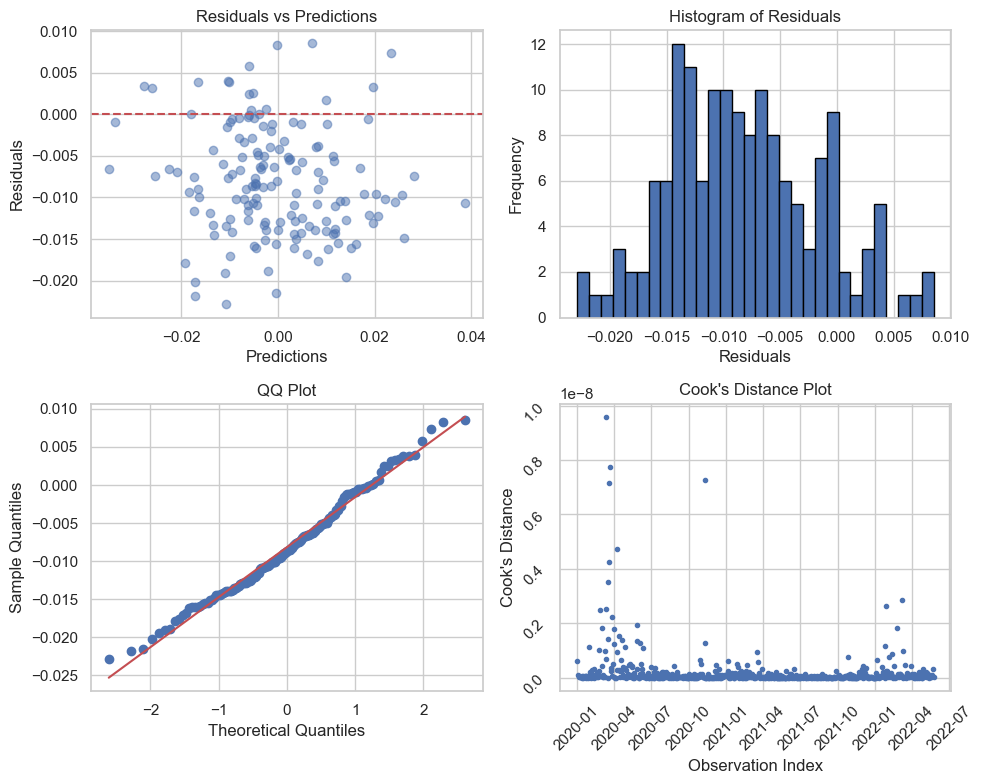

In [18]:
# plot and analyse residuals from the wls model

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].scatter(y_pred_test_wls_3f_ew, y_resid_test_wls_3f_ew, alpha=0.5)
ax[0, 0].axhline(y=0, color='r', linestyle='--')
ax[0, 0].set_title('Residuals vs Predictions')
ax[0, 0].set_xlabel('Predictions')
ax[0, 0].set_ylabel('Residuals')

ax[0, 1].hist(y_resid_test_wls_3f_ew, bins=30, edgecolor='black')
ax[0, 1].set_title('Histogram of Residuals')
ax[0, 1].set_xlabel('Residuals')
ax[0, 1].set_ylabel('Frequency')

probplot(y_resid_test_wls_3f_ew, plot=ax[1, 0], fit=True)
ax[1, 0].set_title('QQ Plot')
ax[1, 0].set_xlabel('Theoretical Quantiles')
ax[1, 0].set_ylabel('Sample Quantiles')

influence = OLSInfluence(model_wls_3f_ew)
cook_distance = influence.cooks_distance[0]

ax[1, 1].plot(cook_distance, 'bo', markersize=3)
ax[1, 1].set_title("Cook's Distance Plot")
ax[1, 1].set_xlabel('Observation Index')
ax[1, 1].set_ylabel("Cook's Distance")
plt.setp(ax[1, 1].get_yticklabels(), rotation=45)
plt.setp(ax[1, 1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

plt.show()

### **RLM - Robust Linear Model**

In [19]:
# fit robust model and print summary
model_robust_3f_ew = sm.RLM(y_train_ew, X_train_3f, M=sm.robust.norms.HuberT()).fit()
print("\nRobust Regression Summary:")
print(model_robust_3f_ew.summary())


Robust Regression Summary:
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  604
Model:                            RLM   Df Residuals:                      600
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 15 Feb 2024                                         
Time:                        17:00:40                                         
No. Iterations:                    27                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003   

In [20]:
# compute and print r2 metrics for the robust model

y_pred_train_robust_3f_ew = model_robust_3f_ew.predict(X_train_3f)
y_pred_test_robust_3f_ew = model_robust_3f_ew.predict(X_test_3f)
y_resid_train_robust_3f_ew = y_train_ew - y_pred_train_robust_3f_ew
y_resid_test_robust_3f_ew = y_test_ew - y_pred_test_robust_3f_ew

r2_robust_train_3f_ew = r2_score(y_train_ew, y_pred_train_robust_3f_ew)
r2_robust_test_3f_ew = r2_score(y_test_ew, y_pred_test_robust_3f_ew)

print('R2 metrics for equally weighted portfolio using robust regression with 3 factors:')
print(f'\tR2 Train: {round(r2_robust_train_3f_ew, 5)}')
print(f'\tR2 Test: {round(r2_robust_test_3f_ew, 5)}')

R2 metrics for equally weighted portfolio using robust regression with 3 factors:
	R2 Train: 0.86306
	R2 Test: 0.36754


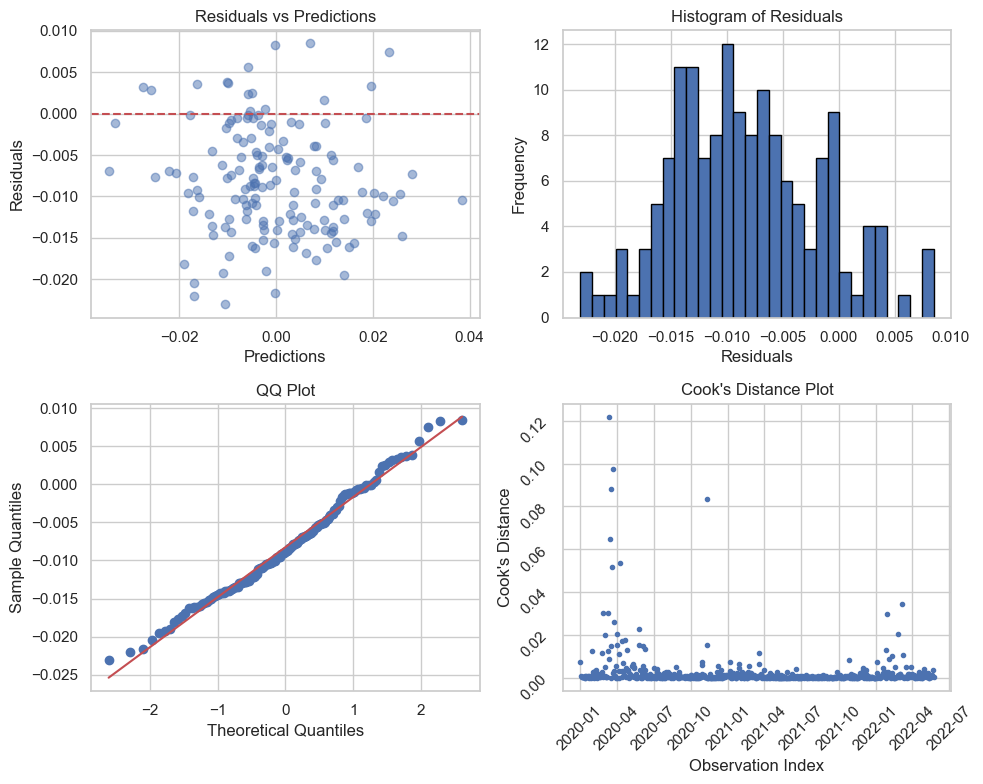

In [21]:
# plot and analyse residuals from the robust model

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].scatter(y_pred_test_robust_3f_ew, y_resid_test_robust_3f_ew, alpha=0.5)
ax[0, 0].axhline(y=0, color='r', linestyle='--')
ax[0, 0].set_title('Residuals vs Predictions')
ax[0, 0].set_xlabel('Predictions')
ax[0, 0].set_ylabel('Residuals')

ax[0, 1].hist(y_resid_test_robust_3f_ew, bins=30, edgecolor='black')
ax[0, 1].set_title('Histogram of Residuals')
ax[0, 1].set_xlabel('Residuals')
ax[0, 1].set_ylabel('Frequency')

probplot(y_resid_test_robust_3f_ew, plot=ax[1, 0], fit=True)
ax[1, 0].set_title('QQ Plot')
ax[1, 0].set_xlabel('Theoretical Quantiles')
ax[1, 0].set_ylabel('Sample Quantiles')

influence = OLSInfluence(model_ols_3f_ew)
cook_distance = influence.cooks_distance[0]

ax[1, 1].plot(cook_distance, 'bo', markersize=3)
ax[1, 1].set_title("Cook's Distance Plot")
ax[1, 1].set_xlabel('Observation Index')
ax[1, 1].set_ylabel("Cook's Distance")
plt.setp(ax[1, 1].get_yticklabels(), rotation=45)
plt.setp(ax[1, 1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

plt.show()

## **Step 4**

### **OLS - Ordinary Least Squares**

In [22]:
# add intercept to the 5 factor data
X_5f = sm.add_constant(factors_data_5f)

# split X_train and X_test for 5 factor data without shuffle
X_train_5f = X_5f.iloc[:train_size]
X_test_5f = X_5f.iloc[train_size:]

In [23]:
# fit OLS model and print summary
model_ols_5f_ew = sm.OLS(y_train_ew, X_train_5f).fit()
print("OLS Regression Summary:")
print(model_ols_5f_ew.summary())

OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     1037.
Date:                Thu, 15 Feb 2024   Prob (F-statistic):          6.55e-292
Time:                        17:00:41   Log-Likelihood:                 2331.9
No. Observations:                 604   AIC:                            -4652.
Df Residuals:                     598   BIC:                            -4625.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0

In [24]:
# compute and print r2 metrics for the ols model
y_pred_train_ols_5f_ew = model_ols_5f_ew.predict(X_train_5f)
y_pred_test_ols_5f_ew = model_ols_5f_ew.predict(X_test_5f)
y_resid_train_ols_5f_ew = y_train_ew - y_pred_train_ols_5f_ew
y_resid_test_ols_5f_ew = y_test_ew - y_pred_test_ols_5f_ew

r2_ols_train_5f_ew = r2_score(y_train_ew, y_pred_train_ols_5f_ew)
r2_ols_test_5f_ew = r2_score(y_test_ew, y_pred_test_ols_5f_ew)

print('R2 metrics for equally weighted portfolio using OLS regression with 5 factors:')
print(f'\tR2 Train: {round(r2_ols_train_5f_ew, 5)}')
print(f'\tR2 Test: {round(r2_ols_test_5f_ew, 5)}')

R2 metrics for equally weighted portfolio using OLS regression with 5 factors:
	R2 Train: 0.89664
	R2 Test: 0.32832


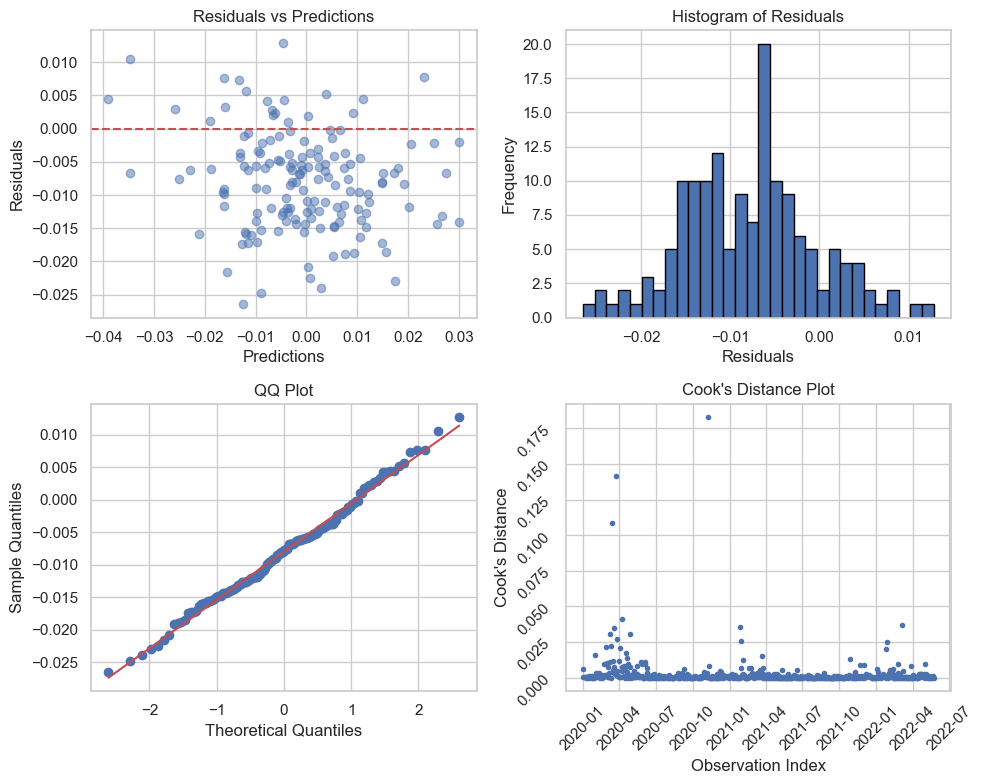

In [25]:
# plot and analyse residuals from the ols model

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].scatter(y_pred_test_ols_5f_ew, y_resid_test_ols_5f_ew, alpha=0.5)
ax[0, 0].axhline(y=0, color='r', linestyle='--')
ax[0, 0].set_title('Residuals vs Predictions')
ax[0, 0].set_xlabel('Predictions')
ax[0, 0].set_ylabel('Residuals')

ax[0, 1].hist(y_resid_test_ols_5f_ew, bins=30, edgecolor='black')
ax[0, 1].set_title('Histogram of Residuals')
ax[0, 1].set_xlabel('Residuals')
ax[0, 1].set_ylabel('Frequency')

probplot(y_resid_test_ols_5f_ew, plot=ax[1, 0], fit=True)
ax[1, 0].set_title('QQ Plot')
ax[1, 0].set_xlabel('Theoretical Quantiles')
ax[1, 0].set_ylabel('Sample Quantiles')

influence = OLSInfluence(model_ols_5f_ew)
cook_distance = influence.cooks_distance[0]

ax[1, 1].plot(cook_distance, 'bo', markersize=3)
ax[1, 1].set_title("Cook's Distance Plot")
ax[1, 1].set_xlabel('Observation Index')
ax[1, 1].set_ylabel("Cook's Distance")
plt.setp(ax[1, 1].get_yticklabels(), rotation=45)
plt.setp(ax[1, 1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

plt.show()

### **WLS - Weighted Least Squares**

In [26]:
# fit wls model and print summary
model_resid_5f_ew = sm.OLS(abs(y_resid_train_ols_5f_ew), sm.add_constant(y_pred_train_ols_5f_ew)).fit()
weights = 1 / (model_resid_5f_ew.fittedvalues**2)

model_wls_5f_ew = sm.WLS(y_train_ew, X_train_5f, weights=weights).fit()
print("WLS Regression Summary:")
print(model_wls_5f_ew.summary())

WLS Regression Summary:
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.898
Model:                            WLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     1050.
Date:                Thu, 15 Feb 2024   Prob (F-statistic):          2.75e-293
Time:                        17:00:42   Log-Likelihood:                 2332.0
No. Observations:                 604   AIC:                            -4652.
Df Residuals:                     598   BIC:                            -4626.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0

In [27]:
# compute and print r2 metrics for the wls model

y_pred_train_wls_5f_ew = model_wls_5f_ew.predict(X_train_5f)
y_pred_test_wls_5f_ew = model_wls_5f_ew.predict(X_test_5f)
y_resid_train_wls_5f_ew = y_train_ew - y_pred_train_wls_5f_ew
y_resid_test_wls_5f_ew = y_test_ew - y_pred_test_wls_5f_ew

r2_wls_train_5f_ew = r2_score(y_train_ew, y_pred_train_wls_5f_ew)
r2_wls_test_5f_ew = r2_score(y_test_ew, y_pred_test_wls_5f_ew)

print('R2 metrics for equally weighted portfolio using WLS regression with 5 factors:')
print(f'\tR2 Train: {round(r2_wls_train_5f_ew, 5)}')
print(f'\tR2 Test: {round(r2_wls_test_5f_ew, 5)}')

R2 metrics for equally weighted portfolio using WLS regression with 5 factors:
	R2 Train: 0.89656
	R2 Test: 0.33018


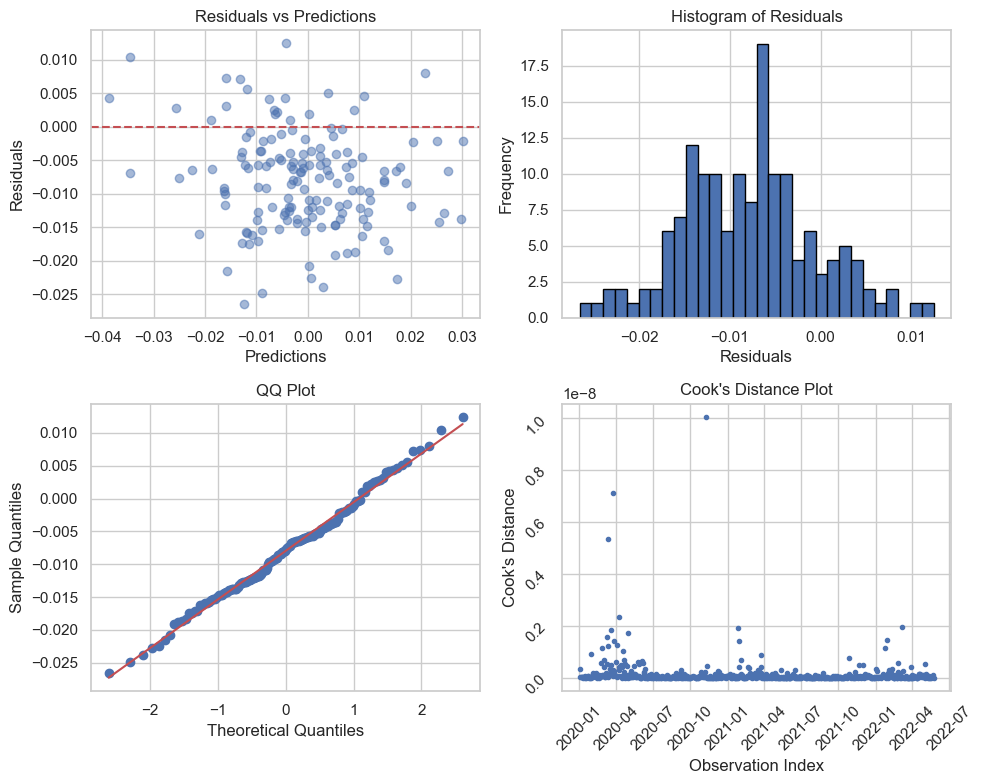

In [28]:
# plot and analyse residuals from the wls model

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].scatter(y_pred_test_wls_5f_ew, y_resid_test_wls_5f_ew, alpha=0.5)
ax[0, 0].axhline(y=0, color='r', linestyle='--')
ax[0, 0].set_title('Residuals vs Predictions')
ax[0, 0].set_xlabel('Predictions')
ax[0, 0].set_ylabel('Residuals')

ax[0, 1].hist(y_resid_test_wls_5f_ew, bins=30, edgecolor='black')
ax[0, 1].set_title('Histogram of Residuals')
ax[0, 1].set_xlabel('Residuals')
ax[0, 1].set_ylabel('Frequency')

probplot(y_resid_test_wls_5f_ew, plot=ax[1, 0], fit=True)
ax[1, 0].set_title('QQ Plot')
ax[1, 0].set_xlabel('Theoretical Quantiles')
ax[1, 0].set_ylabel('Sample Quantiles')

influence = OLSInfluence(model_wls_5f_ew)
cook_distance = influence.cooks_distance[0]

ax[1, 1].plot(cook_distance, 'bo', markersize=3)
ax[1, 1].set_title("Cook's Distance Plot")
ax[1, 1].set_xlabel('Observation Index')
ax[1, 1].set_ylabel("Cook's Distance")
plt.setp(ax[1, 1].get_yticklabels(), rotation=45)
plt.setp(ax[1, 1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

plt.show()

### **RLM - Robust Linear Models**

In [29]:
# fit robust model and print summary
model_robust_5f_ew = sm.RLM(y_train_ew, X_train_5f, M=sm.robust.norms.HuberT()).fit()
print("\nRobust Regression Summary:")
print(model_robust_5f_ew.summary())


Robust Regression Summary:
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  604
Model:                            RLM   Df Residuals:                      598
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 15 Feb 2024                                         
Time:                        17:00:43                                         
No. Iterations:                    25                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006   

In [30]:
# compute and print r2 metrics for the robust model

y_pred_train_robust_5f_ew = model_robust_5f_ew.predict(X_train_5f)
y_pred_test_robust_5f_ew = model_robust_5f_ew.predict(X_test_5f)
y_resid_train_robust_5f_ew = y_train_ew - y_pred_train_robust_5f_ew
y_resid_test_robust_5f_ew = y_test_ew - y_pred_test_robust_5f_ew

r2_robust_train_5f_ew = r2_score(y_train_ew, y_pred_train_robust_5f_ew)
r2_robust_test_5f_ew = r2_score(y_test_ew, y_pred_test_robust_5f_ew)

print('R2 metrics for equally weighted portfolio using robust regression with 5 factors:')
print(f'\tR2 Train: {round(r2_robust_train_5f_ew, 5)}')
print(f'\tR2 Test: {round(r2_robust_test_5f_ew, 5)}')

R2 metrics for equally weighted portfolio using robust regression with 5 factors:
	R2 Train: 0.8964
	R2 Test: 0.32806


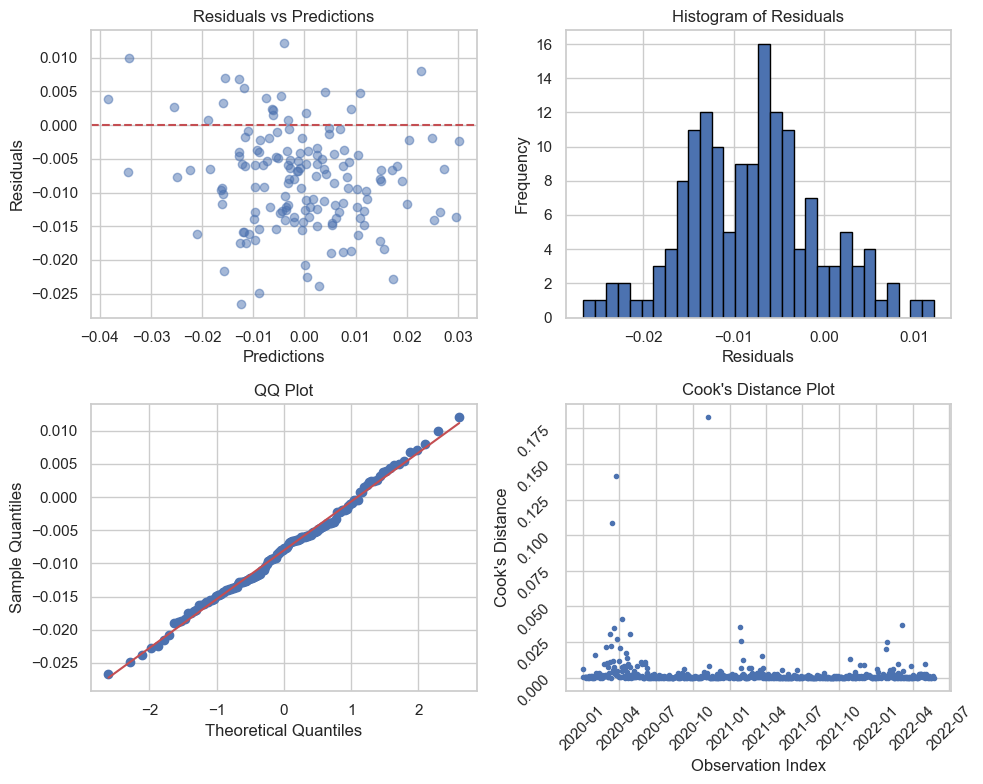

In [31]:
# plot and analyse residuals from the robust model

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].scatter(y_pred_test_robust_5f_ew, y_resid_test_robust_5f_ew, alpha=0.5)
ax[0, 0].axhline(y=0, color='r', linestyle='--')
ax[0, 0].set_title('Residuals vs Predictions')
ax[0, 0].set_xlabel('Predictions')
ax[0, 0].set_ylabel('Residuals')

ax[0, 1].hist(y_resid_test_robust_5f_ew, bins=30, edgecolor='black')
ax[0, 1].set_title('Histogram of Residuals')
ax[0, 1].set_xlabel('Residuals')
ax[0, 1].set_ylabel('Frequency')

probplot(y_resid_test_robust_5f_ew, plot=ax[1, 0], fit=True)
ax[1, 0].set_title('QQ Plot')
ax[1, 0].set_xlabel('Theoretical Quantiles')
ax[1, 0].set_ylabel('Sample Quantiles')

influence = OLSInfluence(model_ols_5f_ew)
cook_distance = influence.cooks_distance[0]

ax[1, 1].plot(cook_distance, 'bo', markersize=3)
ax[1, 1].set_title("Cook's Distance Plot")
ax[1, 1].set_xlabel('Observation Index')
ax[1, 1].set_ylabel("Cook's Distance")
plt.setp(ax[1, 1].get_yticklabels(), rotation=45)
plt.setp(ax[1, 1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

plt.show()

## **Step 5**

### **a. Compute correlation and covariance matrix of the factor returns**

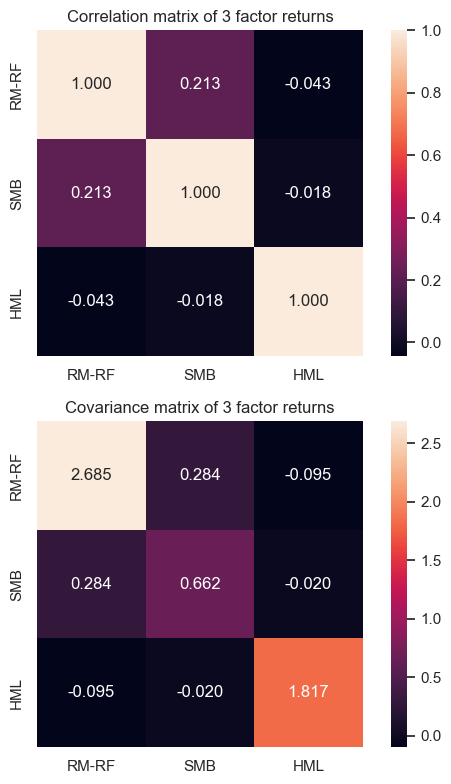

In [32]:
# Compute and plot correlation and covariance matrix of the 3 factor returns

corr = factors_data_3f.corr()
cov = factors_data_3f.cov()

fig, ax = plt.subplots(nrows=2, figsize=(6,8))
sns.heatmap(corr, annot=True, fmt='.3f', ax=ax[0], square=True)
ax[0].set_title('Correlation matrix of 3 factor returns')
sns.heatmap(cov, annot=True, fmt='.3f', ax=ax[1], square=True)
ax[1].set_title('Covariance matrix of 3 factor returns')
plt.tight_layout()
plt.show()

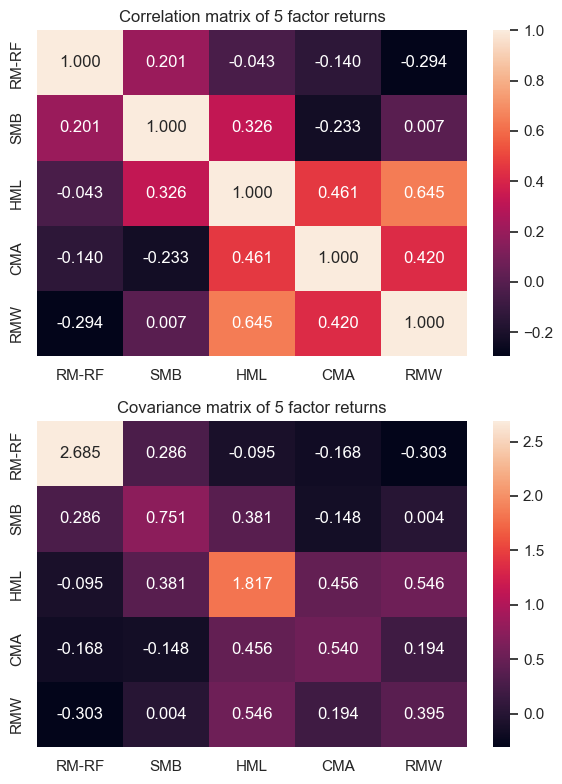

In [33]:
# Compute and plot correlation and covariance matrix of the 5 factor returns

corr = factors_data_5f.corr()
cov = factors_data_5f.cov()

fig, ax = plt.subplots(nrows=2, figsize=(6,8))
sns.heatmap(corr, annot=True, fmt='.3f', ax=ax[0])
ax[0].set_title('Correlation matrix of 5 factor returns')
sns.heatmap(cov, annot=True, fmt='.3f', ax=ax[1])
ax[1].set_title('Covariance matrix of 5 factor returns')
plt.tight_layout()
plt.show()

## **Step 7**

#### Optimizing weights with no shorting

In [34]:
# instantiate weight as a variable to be optimized
weights_ns = cp.Variable(len(tickers))

# define objective function
objective = cp.Maximize((-1/2)*cp.quad_form(weights_ns, cov_matrix) + mean_returns.T @ weights_ns)

# set constraints
constraints = [cp.sum(weights_ns) == 1, weights_ns >= 0]

# solve problem
problem = cp.Problem(objective, constraints)
problem.solve()

opt_weights_ns = weights_ns.value

# display optimal weights
optimal_portfolio_ns = pd.DataFrame({'Stock': tickers, 'Optimal Weight with No Shorting': opt_weights_ns})
optimal_portfolio_ns

,Stock,Optimal Weight with No Shorting
0,AAPL,0.41903
1,JNJ,0.00000
2,V,0.00000
3,PG,0.00000
4,XOM,0.58097


In [35]:
# Compute expected return and volatility of the optimal portfolio without shorting
portfolio_return_ns = np.dot(mean_returns, opt_weights_ns)
portfolio_volatility_ns = np.sqrt(np.dot(opt_weights_ns.T, np.dot(cov_matrix, opt_weights_ns)))

print(f"Optimal Portfolio with no shorting:\nExpected Return: {portfolio_return_ns:.4f}\nVolatility: {portfolio_volatility_ns:.4f}")

Optimal Portfolio with no shorting:
Expected Return: 0.0011
Volatility: 0.0203


In [38]:
opt_weights_ns

array([4.19027450e-01, 1.59870790e-22, 1.72495983e-22, 1.48968157e-22,
       5.80972550e-01])

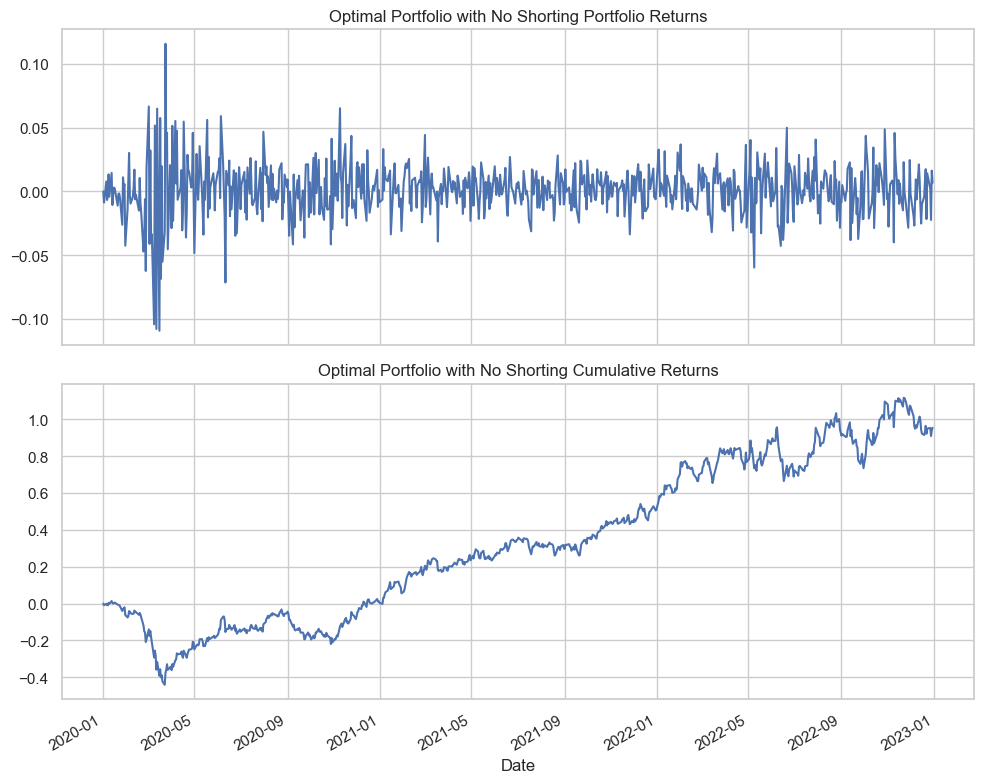

In [36]:
# compute and plot daily returns and cumulative returns of the portfolio
portfolio_returns_ns = np.sum(returns_data * opt_weights_ns, axis=1)
cumulative_returns_ns = (1 + portfolio_returns_ns).cumprod() - 1

fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

portfolio_returns_ns.plot(ax=ax[0], title='Optimal Portfolio with No Shorting Portfolio Returns')
cumulative_returns_ns.plot(ax=ax[1], title='Optimal Portfolio with No Shorting Cumulative Returns', sharex=ax[1])

plt.tight_layout();

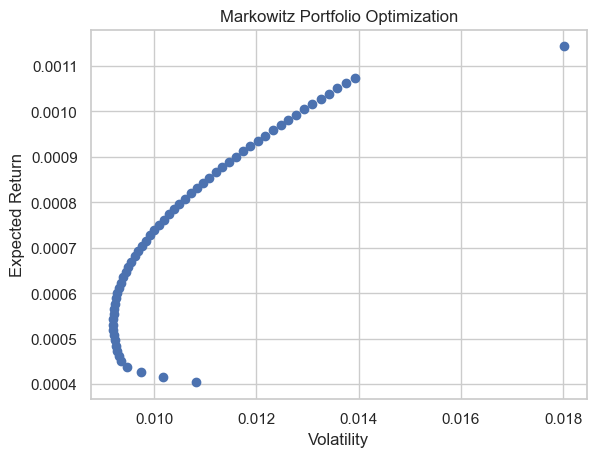

In [37]:
# Plot the efficient frontier
num_points = 100
target_returns = np.linspace(0, max(mean_returns), num_points)
efficient_portfolios_ns = []

for target_return in target_returns:
    constraints = [cp.sum(weights_ns) == 1, weights_ns >= 0, cp.sum(weights_ns.T @ mean_returns) == target_return]
    qp = 1/2 * cp.quad_form(weights_ns, cov_matrix)
    problem = cp.Problem(cp.Minimize(qp), constraints)
    problem.solve()
    efficient_portfolios_ns.append([target_return, np.sqrt(problem.value)])

efficient_portfolios_ns = np.array(efficient_portfolios_ns)
plt.scatter(efficient_portfolios_ns[:, 1], efficient_portfolios_ns[:, 0], marker='o', label='Efficient Frontier')
plt.title('Markowitz Portfolio Optimization')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.show()

In [38]:
# split y_train and y_test without shuffle
y_ns = portfolio_returns_ns - risk_free
y_train_ns = y_ns.iloc[:train_size]
y_test_ns = y_ns.iloc[train_size:]

In [39]:
# fit OLS model and print summary
model_ols_3f_ns = sm.OLS(y_train_ns, X_train_3f).fit()
print("OLS Regression Summary:")
print(model_ols_3f_ns.summary())

OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     541.3
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          3.36e-170
Time:                        19:20:02   Log-Likelihood:                 1874.2
No. Observations:                 604   AIC:                            -3740.
Df Residuals:                     600   BIC:                            -3723.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0

In [40]:
# compute and print r2 metrics for the ols model
y_pred_train_ols_3f_ns = model_ols_3f_ns.predict(X_train_3f)
y_pred_test_ols_3f_ns = model_ols_3f_ns.predict(X_test_3f)
y_resid_train_ols_3f_ns = y_train_ns - y_pred_train_ols_3f_ns
y_resid_test_ols_3f_ns = y_test_ns - y_pred_test_ols_3f_ns

r2_ols_train_3f_ns = r2_score(y_train_ns, y_pred_train_ols_3f_ns)
r2_ols_test_3f_ns = r2_score(y_test_ns, y_pred_test_ols_3f_ns)

print('R2 metrics for optimal portfolio with no shorting using OLS regression with 3 factors:')
print(f'\tR2 Train: {round(r2_ols_train_3f_ns, 5)}')
print(f'\tR2 Test: {round(r2_ols_test_3f_ns, 5)}')

R2 metrics for optimal portfolio with no shorting using OLS regression with 3 factors:
	R2 Train: 0.73022
	R2 Test: 0.48383


In [41]:
# fit OLS model and print summary
model_ols_5f_ns = sm.OLS(y_train_ns, X_train_5f).fit()
print("OLS Regression Summary:")
print(model_ols_5f_ns.summary())

OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     428.6
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          5.53e-195
Time:                        19:20:02   Log-Likelihood:                 1938.3
No. Observations:                 604   AIC:                            -3865.
Df Residuals:                     598   BIC:                            -3838.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0

In [42]:
# compute and print r2 metrics for the ols model
y_pred_train_ols_5f_ns = model_ols_5f_ns.predict(X_train_5f)
y_pred_test_ols_5f_ns = model_ols_5f_ns.predict(X_test_5f)
y_resid_train_ols_5f_ns = y_train_ns - y_pred_train_ols_5f_ns
y_resid_test_ols_5f_ns = y_test_ns - y_pred_test_ols_5f_ns

r2_ols_train_5f_ns = r2_score(y_train_ns, y_pred_train_ols_5f_ns)
r2_ols_test_5f_ns = r2_score(y_test_ns, y_pred_test_ols_5f_ns)

print('R2 metrics for optimal portfolio with no shorting using OLS regression with 5 factors:')
print(f'\tR2 Train: {round(r2_ols_train_5f_ns, 5)}')
print(f'\tR2 Test: {round(r2_ols_test_5f_ns, 5)}')

R2 metrics for optimal portfolio with no shorting using OLS regression with 5 factors:
	R2 Train: 0.78181
	R2 Test: 0.41291


#### Optimizing weights with shorting

In [43]:
# instantiate weight as a variable to be optimized
weights_ws = cp.Variable(len(tickers))

# set maximum shorting allowed
max_shorting = 0.25

# define objective function
objective = cp.Maximize((-1/2)*cp.quad_form(weights_ws, cov_matrix) + mean_returns.T @ weights_ws)

# set constraints
constraints = [cp.sum(weights_ws) == 1, weights_ws >= -max_shorting]

# solve problem
problem = cp.Problem(objective, constraints)
problem.solve()

opt_weights_ws = weights_ws.value

# display optimal weights
optimal_portfolio_ws = pd.DataFrame({'Stock': tickers, 'Optimal Weight with Shorting': opt_weights_ws})
optimal_portfolio_ws

,Stock,Optimal Weight with Shorting
0,AAPL,0.89416
1,JNJ,-0.25000
2,V,-0.25000
3,PG,-0.25000
4,XOM,0.85584


In [44]:
# Compute expected return and volatility of the optimal portfolio without shorting
portfolio_return_ws = np.dot(mean_returns, opt_weights_ws)
portfolio_volatility_ws = np.sqrt(np.dot(opt_weights_ws.T, np.dot(cov_matrix, opt_weights_ws)))

print(f"Optimal Portfolio with shorting:\nExpected Return: {portfolio_return_ws:.4f}\nVolatility: {portfolio_volatility_ws:.4f}")

Optimal Portfolio with shorting:
Expected Return: 0.0016
Volatility: 0.0287


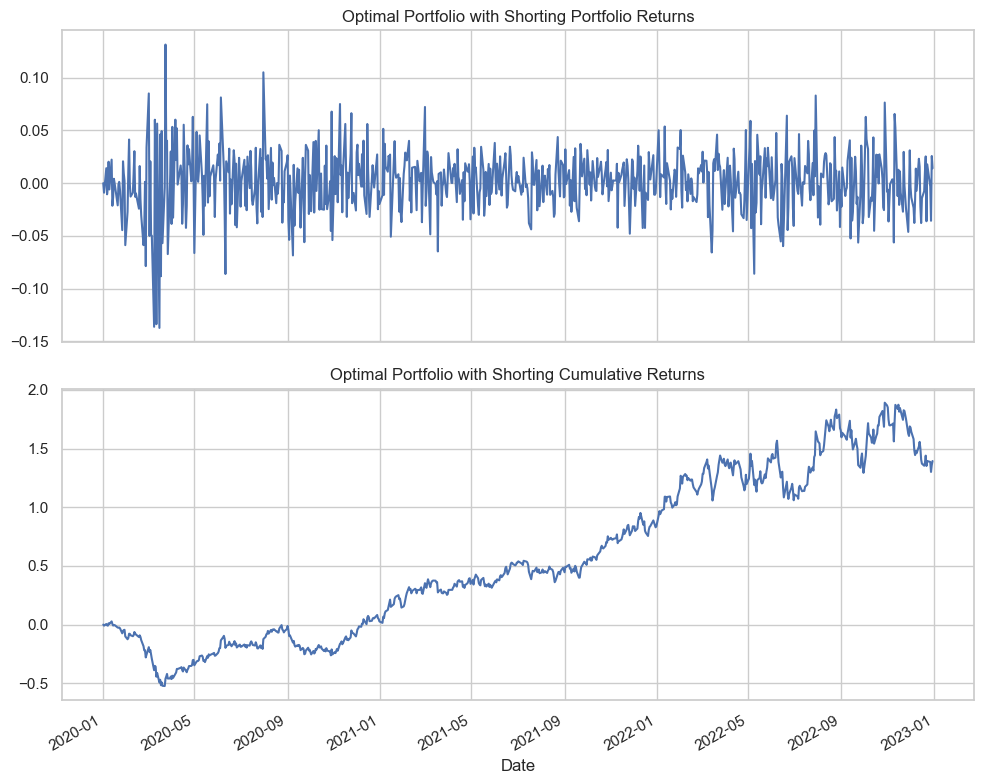

In [45]:
# compute and plot daily returns and cumulative returns of the portfolio
portfolio_returns_ws = np.sum(returns_data * opt_weights_ws, axis=1)
cumulative_returns_ws = (1 + portfolio_returns_ws).cumprod() - 1

fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

portfolio_returns_ws.plot(ax=ax[0], title='Optimal Portfolio with Shorting Portfolio Returns')
cumulative_returns_ws.plot(ax=ax[1], title='Optimal Portfolio with Shorting Cumulative Returns', sharex=ax[1])

plt.tight_layout();

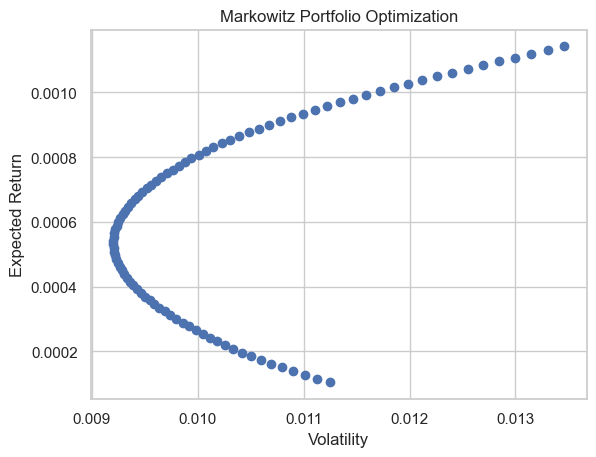

In [46]:
# Plot the efficient frontier
efficient_portfolios_ws = []

for target_return in target_returns:
    constraints = [cp.sum(weights_ws) == 1, weights_ws >= -max_shorting, cp.sum(weights_ws.T @ mean_returns) == target_return]
    qp = 1/2 * cp.quad_form(weights_ws, cov_matrix)
    problem = cp.Problem(cp.Minimize(qp), constraints)
    problem.solve()
    efficient_portfolios_ws.append([target_return, np.sqrt(problem.value)])

efficient_portfolios_ws = np.array(efficient_portfolios_ws)
plt.scatter(efficient_portfolios_ws[:, 1], efficient_portfolios_ws[:, 0], marker='o', label='Efficient Frontier')
plt.title('Markowitz Portfolio Optimization')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.show()

In [47]:
# split y_train and y_test without shuffle
y_ws = portfolio_returns_ws - risk_free
train_size = int(len(y_ew) * 0.8)
y_train_ws = y_ws.iloc[:train_size]
y_test_ws = y_ws.iloc[train_size:]

In [48]:
# fit OLS model and print summary
model_ols_3f_ws = sm.OLS(y_train_ws, X_train_3f).fit()
print("OLS Regression Summary:")
print(model_ols_3f_ws.summary())

OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     266.3
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          7.78e-110
Time:                        19:20:04   Log-Likelihood:                 1537.5
No. Observations:                 604   AIC:                            -3067.
Df Residuals:                     600   BIC:                            -3049.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0

In [49]:
# compute and print r2 metrics for the ols model
y_pred_train_ols_3f_ws = model_ols_3f_ws.predict(X_train_3f)
y_pred_test_ols_3f_ws = model_ols_3f_ws.predict(X_test_3f)
y_resid_train_ols_3f_ws = y_train_ws - y_pred_train_ols_3f_ws
y_resid_test_ols_3f_ws = y_test_ws - y_pred_test_ols_3f_ws

r2_ols_train_3f_ws = r2_score(y_train_ws, y_pred_train_ols_3f_ws)
r2_ols_test_3f_ws = r2_score(y_test_ws, y_pred_test_ols_3f_ws)

print('R2 metrics for optimal portfolio with shorting using OLS regression with 3 factors:')
print(f'\tR2 Train: {round(r2_ols_train_3f_ws, 5)}')
print(f'\tR2 Test: {round(r2_ols_test_3f_ws, 5)}')

R2 metrics for optimal portfolio with shorting using OLS regression with 3 factors:
	R2 Train: 0.57106
	R2 Test: 0.46342


In [50]:
# fit OLS model and print summary
model_ols_5f_ws = sm.OLS(y_train_ws, X_train_5f).fit()
print("OLS Regression Summary:")
print(model_ols_5f_ws.summary())

OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     210.3
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          3.43e-129
Time:                        19:20:04   Log-Likelihood:                 1588.3
No. Observations:                 604   AIC:                            -3165.
Df Residuals:                     598   BIC:                            -3138.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0

In [51]:
# compute and print r2 metrics for the ols model
y_pred_train_ols_5f_ws = model_ols_5f_ws.predict(X_train_5f)
y_pred_test_ols_5f_ws = model_ols_5f_ws.predict(X_test_5f)
y_resid_train_ols_5f_ws = y_train_ws - y_pred_train_ols_5f_ws
y_resid_test_ols_5f_ws = y_test_ws - y_pred_test_ols_5f_ws

r2_ols_train_5f_ws = r2_score(y_train_ws, y_pred_train_ols_5f_ws)
r2_ols_test_5f_ws = r2_score(y_test_ws, y_pred_test_ols_5f_ws)

print('R2 metrics for optimal portfolio with shorting using OLS regression with 5 factors:')
print(f'\tR2 Train: {round(r2_ols_train_5f_ws, 5)}')
print(f'\tR2 Test: {round(r2_ols_test_5f_ws, 5)}')

R2 metrics for optimal portfolio with shorting using OLS regression with 5 factors:
	R2 Train: 0.6375
	R2 Test: 0.3786
